# CB2 Movie recommendation notebook

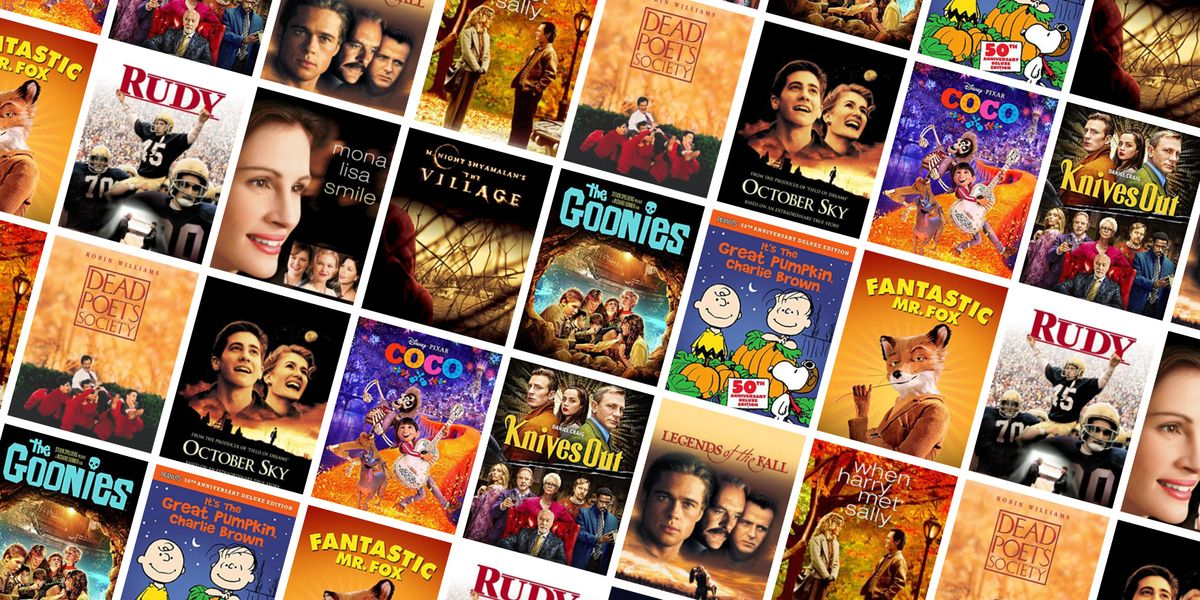

## Table of Contents

1. <a href ="#1.-Introduction">Introduction</a>
2. <a href ="#2.-Evaluation">Evaluation</a>
3. <a href ="#3.-Comet">Comet</a>
4. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
5. <a href ="#5.-Importing-Data">Importing Data</a>
6. <a href ="#6.-Data-Overview">Data Overview</a>
10. <a href ="#10.-Exploratory Data Analysis">Exploratory Data Analysis</a>
8. <a href ="#8.-Modeling">Modeling</a>
9. <a href ="#9.-Conclusion">Conclusion</a>
10. <a href ="#10.-Submission">Submission</a>

## 1. Introduction
In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, the client has tasked us to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

# 2. Evaluation


The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:
                                           

# 3. Comet

In [1]:
!pip install comet_ml
# point comet_ml SDK to www.comet.com installation

# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="h3bQ9KYqt3r8nf4Y9oerJWCNn",
    project_name="cb2-movie-classifier",
    workspace="vicariousvision",
)

COMET INFO: Experiment is live on comet.ml https://www.comet.com/vicariousvision/cb2-movie-classifier/3a421b366eb1404794b12e37c1838fd4



## 4. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import scipy as sp
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle

from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud


# 5. Importing Data

In [3]:
# Movies dataframe
df_movies = pd.read_csv('movies.csv')

# Sample submission
df_sample = pd.read_csv('sample_submission.csv')

# Genome_scores dataframe
df_gesc = pd.read_csv('genome_scores.csv')

# links dataframe
df_links = pd.read_csv('links.csv')

# Genome_tags dataframe
df_getg = pd.read_csv('genome_tags.csv')

# Imbd dataframe
df_imdb = pd.read_csv('imdb_data.csv')

# Tags dataframe
df_tags = pd.read_csv('tags.csv')

# Train dataframe
df_train = pd.read_csv('train.csv')

# Test dataframe 
df_test = pd.read_csv('test.csv')

# 6. Data Overview

We have been given 8 data files to work with an one sample file of what we should output. In these files are records of movie names, name of directors, cast, budget etc. In the data there are two rating sources that have been used, one from imDB and The Movie Database. We will try to use these rating scores in our model building.


In [ ]:
# Contains movieId, title and genre
df_movies.head(3) 

In [ ]:
# Provides a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
df_links.head(2)

In [ ]:
# User assigned for the movies within the dataset. Can be used to group simmilar users or movies
df_tags.head(2) 

In [ ]:
# Data from the imDB. Contains movieID, cast, director, runtime, budget and key words that are associated with its plot
df_imdb.head(2)

In [ ]:
# The data we will be training the model on. Time stamp could be dropped from this data.
df_train.head(2) 

In [ ]:
# We're working with int data types which works for the models we are using
df_train.info() 

In [ ]:
df_movies.info()

# 7. Exploratory Data Analysis

In [ ]:
# The amount of users in the database
df_train["userId"].nunique() 

In [ ]:
# The number of movies in the database
df_train.movieId.nunique() 

Lets take a look at the average rating of users and the average amount of movies watched by users. Firstly we will create a new dataframe with a users average rating and the number of movies and the number of times they have rated movies

In [ ]:
# Dataframe consisting of the users average rating and number of times they have rated movies
df1 = pd.DataFrame(df_train.groupby('userId')['rating'].agg('mean').reset_index())
df2 = pd.DataFrame(df_train.groupby('userId')['rating'].count().reset_index())

# Merge the above to dataframe 
df1 = df1.merge(df2,on='userId',how = 'left')

# Rename the columns respectively
df1.rename(columns={'rating_x':'avg_rating','rating_y':'number_of_movies'},inplace = True)

# Sort the data in descending 
df1 = df1.sort_values('number_of_movies', ascending = False)

# Show 5 observations 
df1.head()

In [ ]:
# Create a plot with set figure size
fig, ax = plt.subplots(1,2,figsize=(20, 10)) 

# Create a densityplot 
sns.kdeplot(ax=ax[0], x='avg_rating', data=df1) 
ax[0].set_title("The average rating of users",fontsize = 20)

# Set the axis labels to appear in standard form
plt.ticklabel_format(style='plain', axis='y', useOffset=False) 

# Create a KDE* plot of the rating the users 
sns.kdeplot(ax=ax[1], x='number_of_movies', data=df1[1:]) 
ax[1].set_title("A Density plot showing the average number of movies watched by the users",fontsize = 20)
    
# Show density plot
plt.show()

So most of the users ratings fall toward the positive side of the rating scale. This could mean that users are lenient or the movies that they have seen are just that good. 
*A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions. 

In [ ]:
# Create plot to show average number of movies per user and rating per user
fig,ax = plt.subplots(1,2,figsize = (20,10))

sns.boxplot(ax =ax[0],x = df1.iloc[10:,2])

ax[0].set_title("Average number of movies watch per user", fontsize = 15)
sns.boxplot(ax = ax[1],x = df1.iloc[10:,1] )

ax[1].set_title("Average rating per user", fontsize = 15)
plt.show()

Looking at this box plot we can see that most users have seen less than 1000 movies, there are many users however who are outliers and have seen thousands of movies. Once again we see that the average rating is high.

In [ ]:
#  # Initialize the plot with set figure size
fig, ax = plt.subplots(figsize=(20, 10))

# Create a countplot to visualise the number of movies per category
sns.countplot(ax=ax, x='rating', data=df_train) 
ax.set_title("The number of movies for each ratings")

# Set the  labels to appear in non-scientific form
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

# Place the counts on top of the bars
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    
# Show the countplot
plt.show()

From the countplot, 60579966 movies in the dataset where rated 3.0 or above where most were rated given the rating of 4.0. Most of the movies in the data were very good considering the amount of movies that were rated 4.0 or above. With further scrutiny of the data, the observations acquired from the above chart will be explained in the next incoming sections.

From this bar chart we can see the actual number of movies that were rated in a certain rating class. We note that most movies are rated with a 4.


In [ ]:
# Create an empty list to add genres to
genres=[]

# Loop over the df_movies dataframe
for genre in df_movies.genres:
    
    x=genre.split('|')
    for i in x:
         if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in df_movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)  


# Creates a wordcloud object
wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(movie_title)


# Show word cloud
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=15)
plt.imshow(wordcloud_genre)



From the word cloud we can see that the most occuring genres that could be linked to family movies which would make sense since they are often easy to market and could be seen as a steady stream of income for movie studios so they would be more inclined to make more of them

Lets look at the distribution of tags in the user defined tags dataset

In [ ]:
# Adds just the tags column to a new DatFrame
tag_count = pd.DataFrame(df_tags['tag'].
                           value_counts()).reset_index()

# Rename the columns
tag_count.rename(columns = {'index': 'genre', 'tag': 'count'},
                   inplace = True)

In [ ]:
# Selects top 10 tags and shows the bar plot
temp=tag_count[:10]
sns.barplot(x='genre',y='count',data=temp)

Here we see 'sci-fi' being the most tagged movie genre by users

Lets take a look at the 10 movies by rating in the dataset

In [ ]:
# Creates a new DataFrame by mergeing the train and movies DataFrames
df_top10=pd.merge(df_train,df_movies, how='left',on='movieId')

# Group by title and rating and get its sum
df1=df_top10.groupby(['title'])[['rating']].sum()
high_rated=df1.nlargest(10,'rating')


In [ ]:
# Create bar plot
sns.set_theme(style="whitegrid")
ax=sns.barplot(x=high_rated.index, y=high_rated['rating'], data=high_rated)
ax.figure.set_size_inches(30,10)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.xlabel('Title', fontsize=20);
plt.xticks(fontsize=20,rotation=90)
plt.ylabel('Number of Ratings', fontsize=16);
plt.title('Top 10 movies', fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
# Ploting top genres in the movies dataset
plt.figure(figsize=(30, 10))
gen = df_movies['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:10],color='green')
ax.set_title('Top genres', fontsize=30)

plt.xticks(rotation =90, fontsize=30)
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 90})
plt.show()

Drama and Comedy are the most popular genres, followed by Thriller and Romance. We need to keep in mind that the movies could have multiple genres.

From the graph below we can see the top 10 users with the most ratings

In [ ]:
# Gets user ratings as a new DataFrame, renames columns and plots 
user_rating_count = pd.DataFrame(
    df_train['userId'].value_counts()).reset_index()
user_rating_count.rename(columns={'index':'userId','userId':'count'},
                  inplace=True)
f=user_rating_count.head(10)
f.plot.bar(x="userId", y="count")

Looking at the amount of movies released by year starting at the oldest year

In [ ]:
# Create a list to add the years to
dates = []

# Loops over all titles in the DataFrame and gets the year and adds it to the dates list
for title in df_movies['title']:
    if title[-1] == " ":
        year = title[-6: -2]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)
    else:
        year = title[-5: -1]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)

df_movies['release year'] = dates
df_movies['release year'].unique()


years = pd.DataFrame(df_movies['release year'].
                       value_counts()).reset_index()
years.rename(columns={'index': 'year', 'release year': 'count'},
               inplace=True)


In [ ]:
# Plotting the graph from the data created in the above cell
plt.figure(figsize = (30,8))
ax = sns.barplot(x = 'year', y = 'count',data = years)
plt.xticks(rotation=90)

# 8. Modeling

We will try two approaches. Collaborative and content filtering. The first method is based on content ratings, the second is based on the how users rate the content. 

Firstly we try a content based approach. We will use a portion of the data as the dataset is substantial and using it in its entierty would be computationaly expensive. Content-based filtering makes recommendations by using keywords and attributes assigned to objects in a database (e.g., items in an online marketplace and in our case movie genres) and matching them to a user profile creating some form of feature matrix. The user profile is created based on data derived from a user’s actions, such as purchases, ratings (likes and dislikes), downloads, items searched for on a website and/or placed in a cart, and clicks on product links. An example of a feature matrix:

![Matrix](https://developers.google.com/machine-learning/recommendation/images/Matrix1.svg)

This method relies heavily on the similarities between features and relies on the feature matrix to compute the similarities between each features. The similarities are obtained by finding the distance using the cosine distance metric.

Cosine distance metric is calculated using the dot product 2 vectors over their norms. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1. cosine

![image](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2015/04/cosine.png?w=697&ssl=1)

In [ ]:
# We split the dataframe to make it easier to compute, we will use a poirtion of it and lets look what it looks like
df_movies.iloc[:3121,:] 

Now having taking a sample of the data from the database we will perform some cleaning on the column of interest, the genre column. We look at this beacuse we would like to make recommendatons based on the simmilarity of genres as users can often times have narrow taste profiles when it comes to movies. For example women, enjoy Romantic movies more than men and they would enjoy less than men would whereas men would enjoy Horror more than women on average. 


Source: https://www.statista.com/statistics/254115/favorite-movie-genres-in-the-us/

#### Most popular movie genres among adults in the United States as of December 2018, by gender:

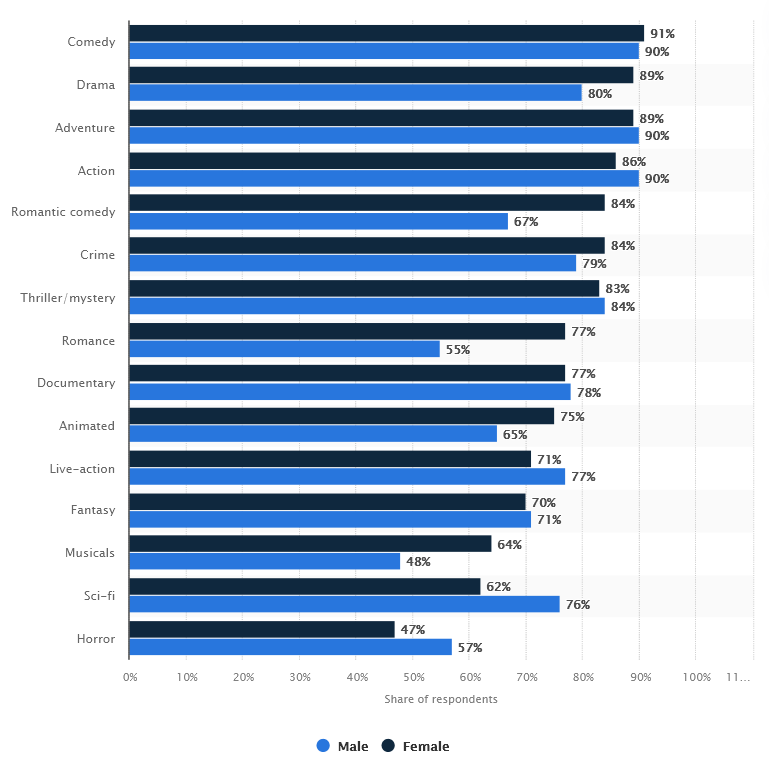

In [ ]:
# Halves the data and replaces the "|" with an empty space
df_half = df_movies.iloc[:31210,:]
df_half['genres']=df_half['genres'].str.replace("|"," ") #remove the | delimter

In [ ]:
# Converts text to numbers
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

# Creates a sparse matrix based on the frequency of genre words
tfidf_matrix = tf.fit_transform(df_half['genres'])  

In [ ]:
# Imports the cosine similarity libray 
from sklearn.metrics.pairwise import cosine_similarity

# Creates a matrix based on the similarity of the features
cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix) 

# Taking a look to see if we have correct outputs
cosine_sim[0] 

In [ ]:
df_half = df_half.reset_index()
titles = df_half['title']
indices = pd.Series(df_half.index, index=df_half['title'])

In [ ]:
def movie_recommendations(title):
    """ 
        This function recommends movies based on the genres associated with an input movie title
        
        Inputs:
        'movie_title (year)'
        
        Returns:
        List of movies simmilar to input movie based on its similarity score
    
    """
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
movie_recommendations('Toy Story (1995)').head()

This model was based on the calculating the cosine simmilarity between genres associated with a movie and the simmilar movies that have simmilar scores. Often users browsing a site for movies would navigate to specific categories like drama, action or comedy and would find movies that have those as a main category with other genres acting as sub-categories. For example the movie Deadpool(2016) is an action movie but can also be said to be a comedy movie. 

While this model works for some movies, running the function on Toy Story as above returns simmilar animated childrens movies and the Toy Story sequel but for more complex queries it is somewhat innacurate. For example entering Batman: Mask of the Phantasm (1993) doesn't return a list of all the other Batman movies, as we would expect it to, it returns movies that are also kids movies but something a fan of Batman would rather not watch like Charlotte's Web. The likely reason for this is that this cosine method is computationally expensive so we had to use a portion of the data to build the model.

In [ ]:
movie_recommendations('Batman: Mask of the Phantasm (1993)').head()

In [ ]:
movie_recommendations('The Jungle Book (2016)').head()

### Collaborative Filtering

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We will attempt two methods. Firstly using Pyspark's ALS (Alternating least squares) method which is used in big data analysis to analyse problems such as movie recommendations. Secondly we will use SVD (Single Value decomposition)


How it works:

[1]"In collaborative filtering, matrix factorization is the state-of-the-art solution for sparse data problem, although it has become widely known since Netflix Prize Challenge. Matrix factorization is simply a family of mathematical operations for matrices in linear algebra. To be specific, a matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.









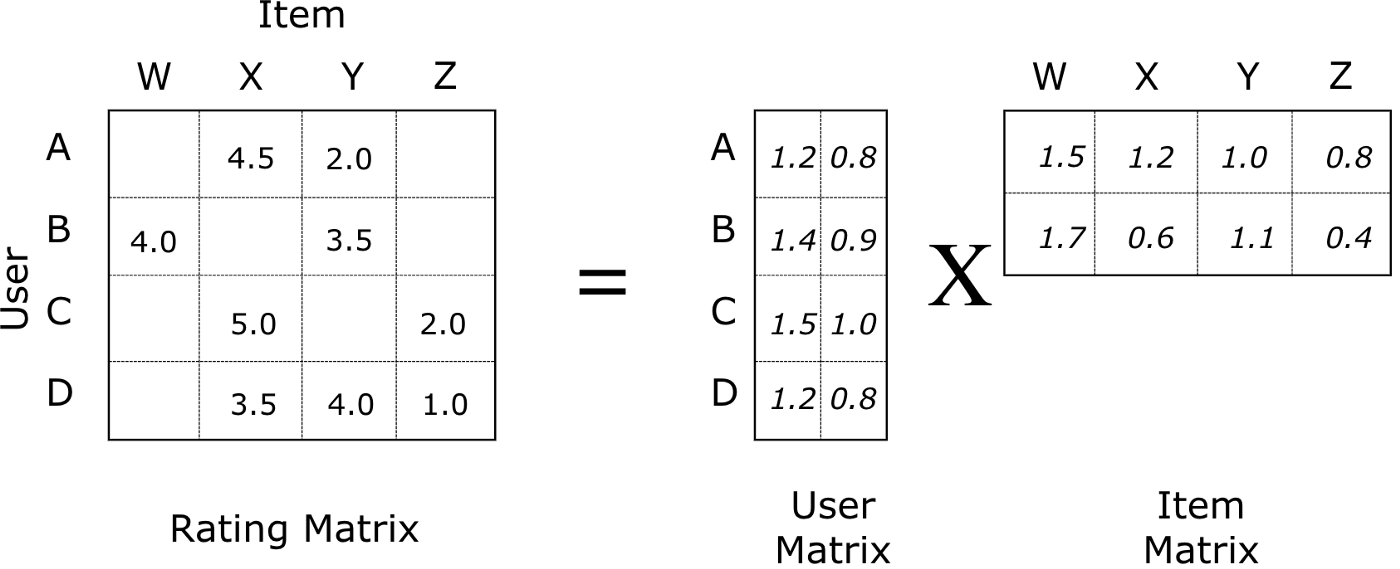

How does matrix factorization solve our problems?

- Model learns to factorize rating matrix into user and movie representations, which allows model to predict better personalized movie ratings for users
- With matrix factorization, less-known movies can have rich latent representations as much as popular movies have, which improves recommender’s ability to recommend less-known movies"

### Using Pyspark

Pyspark's ALS() method:

ALS stands for Alternating Least Squares, a method of matrix factorization. This method is really useful for deployment to server applications as it is optimized to run on distributed computers. This ALS model was built for tasks such as movie or product recommendations

- It comes with builin methods like  .recommendForAllItems() and recommendForAllUsers() which can be used as a content based systems outputs as it can recommend movies that are simmilar to other movies. 
- It has options like 'rating', 'userId' and '

In [36]:
# Make sure we use the right python environment for pyspark
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [37]:
# This code creates a spark session 
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option") \
    .getOrCreate()

In [38]:
# Pyspark can work like pandas and has its own version of a DataFrame with the added advantage of using SQL to query they data
movies_df = spark.read.load("movies.csv", format='csv', header = True)
ratings_df = spark.read.load("train.csv", format='csv', header = True)
links_df = spark.read.load("links.csv", format='csv', header = True)
tags_df = spark.read.load("tags.csv", format='csv', header = True)

In [ ]:
# For example we can use the join feature like in pandas to join two DataFrames on a certain feautre
ratings_df.join(movies_df,'movieId').show(2)

In [39]:
# Import the model and evaluation classes
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Import data into a spark DataFrame
ratings = spark.read.load("train.csv", format='csv', header = True)

# Data type convert from string to int
from pyspark.sql.types import IntegerType, FloatType
ratings = ratings.withColumn("userId", ratings["userId"].cast(IntegerType()))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast(IntegerType()))
ratings = ratings.withColumn("rating", ratings["rating"].cast(FloatType()))



# Train test split
(training, test) = ratings.randomSplit([0.8, 0.2])


# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

Root-mean-square error = 0.8204332825237788


As we can see the RMSE is 0.820, which is not too bad for our uses but with futher study it can be improved.

In [ ]:
# Read in the test data
test2 = spark.read.load("test.csv", format='csv', header = True)

# Change the column data type
test2 = test.withColumn("userId", test["userId"].cast(IntegerType()))
test2 = test.withColumn("movieId", test["movieId"].cast(IntegerType()))

# Predict on unseen data and drop na entires. Show the DataFrame with predicted values
predict_df = model.transform(test2).na.drop()
predict_df.show()

# Remove NaN values from prediction (due to SPARK-14489 error)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))

In [ ]:
# Convert spark DataFrame to Pandas DataFrame
SparkDF = predicted_test_df.toPandas()
SparkDF.head(3)

In [ ]:
# Combining the movieId and userId into one column
SparkDF['Id'] = SparkDF['userId'].astype(str)  + '_'+ SparkDF['movieId'].astype(str) 

In [ ]:
# Rename columns and delete uneeded columns for submission
SparkDF.rename(columns = {'prediction':'rating'}, inplace = True)
del SparkDF['userId']
del SparkDF['movieId']
SparkDF = SparkDF[['Id','rating']]
SparkDF

### SVD method

Just like a number such as 24 can be decomposed as factors 24=2×3×4, a matrix can also be expressed as a multiplication of some other matrices. Because matrices are arrays of numbers, they have their own rules of multiplication, one of them being singular value decomposition, which has no restriction to the shape or properties of the matrix to be decomposed. In simple terms this means from an original matrix (our matrix of ratings similarities in this case) we can break it up into its constituent parts (smaller matrices). 

For example say we have a matrix of user preference data (how they rate each movie) and we want to be able to recommend them movies. Sometimes users will have missing data because they may have not seen all the movies in the database so we “learn” the missing ratings by approximating what they would have rated the movies by decomposing the original matrix by “guessing” values that are missing in the decomposed matrix that are best able to predict the data in the original matrix with the lowest error overall. Then we multiply the decomposed matrices back to get the missing ratings from the original. 

Here is a video with an animation that explains how it works: https://www.youtube.com/watch?v=n3RKsY2H-NE



In [40]:
# Import training data in to a new DataFrame and delete uneeded column
df = pd.DataFrame(df_train)
del df['timestamp']


# This scales the ratings to make sure its only in the 0-5 range
reader = Reader(rating_scale=(0, 5))

# Makes sure the columns are correctly labled and applies the reader object to the DataFrame
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [42]:
# Allows us to train on the whole dataset
trainset = data.build_full_trainset()

# SVD algorithm is called here. For the sake of comuptation and time, we will use just 50 factors and 42 as the random state
algo = SVD(random_state =42,n_factors =50)

# Train the algorithm on the trainset
algo.fit(trainset)

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(df, test_size=.25)

#  Predict ratings for the testset
predictions = [algo.predict(row.userId, row.movieId) for _,row in testset.iterrows()]

# Then compute RMSE
accuracy.rmse(predictions)

As we can see from the RMSE value above, the SVD performs better than the ALS method. This will be the method we will use for our final model.

In [ ]:
 # Pickle our models so they can be used for deployment
import pickle

# SVD Model
filename = 'model.pkl'
pickle.dump(algo, open(filename, 'wb'))

# ALS model
import pickle
filename = 'model2.pkl'
pickle.dump(als, open(filename, 'wb'))

In [8]:
# Save parameters to a dict and save to comet
svd_params = dict(random_state =42,n_factors =50)
experiment.log_parameters(svd_params)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/vicariousvision/cb2-movie-classifier/3a421b366eb1404794b12e37c1838fd4
COMET INFO:   Parameters:
COMET INFO:     n_factors    : 50
COMET INFO:     random_state : 42
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (3 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO: ---------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploading

## 9. Conclusion
In this project we set out to build a machine learning model that would be able to recommend movies based on users ratings and movie specific features. We attempted two approaches in doing this, firstly by basing the recommendation on the ratings and secondly on the movies themsleves. For the collaborative approach we used Pyspark and the SVD method. We found that SVD offers the lowest RMSE score which means it is the better method to use. Pyspark is used for big data analysis and has added benefits that it runs on the Apache Spark platform which makes it possible to interface with other big data and server side languages like Java, Scala and SQL. This is great for deployment as it is built to be distributed over large computing clusters and performs better with optimization. This notebook serves as a proof of concept that building a recommendation system is possible at the small scale but the real value comes when it is applied on a large scale with a larger data set to be trained on and deployed for business use. 

##### How this serves the business:

Recommendation engines have the ability to make or break a business and we emphasize the importance of having something like it to meet the demands of customers in a rapidly growing field. Many large companies have different systems that are always being updated with the latest methods to recommend customers the products they most likely to either purchase or watch. The value in this system lies in keeping customers on the streaming platform for longer doing so has multiple benefits to the companies financial interest. 

###### Recommendations for further analysis and deployment

Firstly, having a system that is accurate (or close to perfect) at predicting customer tastes has the potential to keep customers coming back to the service time and time again. People like to see things that they like, most of the time, or things just on the edge of their taste profiles. There will always be some issue with new users to a platform which could be addressed by imputing missing data or making users take a survey when the sign up to offert the better recommendations. 

Secondly, more investigation could be done into improving the model or introducing a mixture of models that taget specific ways we can recommend better movies. For example we could build a model that takes in per-session data. This could work by looking at how long a user spending watching a trailer on the platform, how long they read the description, where they navigate to on the platform and how they get there, we could look at the time of day, week, month year to recommend movies that fit holiday periods 

Thirdly, as the models we employed make use of thousands of small calculations, they would benefit greatly from being run on GPUs as opposed to CPUs. This is a heafty investment as modern high performance GPUs are expensive due to the boom in crypto mining. There are many cloud options available that will allow us to scale up and down as needed and further study could be done into the viability of such services.


## 10. Submission

In [9]:
# Creates a new list and predicts scores based on every movieId and userId pair for all rows
submission_df = [algo.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]

In [11]:
# Creates a new DataFrame from the list above 
preds = pd.DataFrame(submission_df)

# Rename columns and drop uneeded columns
preds=preds.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
preds.drop(['r_ui','details'],axis=1,inplace=True)

# Formats the Id column into the format needed by kaggle
preds['Id']=preds.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
preds['Id']=preds.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

# Drop the features that will not be required for the submission
preds.drop(['userId', 'movieId'], inplace=True, axis= 1)
# Change positioning of columns
preds = preds[['Id', 'rating']]

# Create Submission file
preds.to_csv("submission.csv", index=False)
preds

,Id,rating
0,1_2011,3.374887
1,1_4144,4.131709
2,1_5767,3.526484
3,1_6711,3.714888
4,1_7318,2.438358
...,...,...
5000014,162541_4079,3.320932
5000015,162541_4467,3.585277
5000016,162541_4980,2.687083
5000017,162541_5689,3.196372


References:
[1] https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1